In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


/home/hawejot/anaconda3/envs/tf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-11-15 14:21:26.170319: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-15 14:21:26.194299: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-15 14:21:26.194324: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-15 14:21:

In [3]:
( train_ds , test_ds ), ds_info = tfds.load('mnist', split =['train','test'], as_supervised=True, with_info=True)

2023-11-15 14:21:29.305788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-15 14:21:29.309342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-15 14:21:29.309377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-15 14:21:29.311649: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-15 14:21:29.311673: I tensorflow/compile

In [4]:
def prepare_mnist_data(ds):
  # Transform the dataset by mapping each element (feature_dict) to a tuple containing the "image" and "label" components.
  #ds = ds.map(lambda feature_dict: (feature_dict["image"], feature_dict["label"]))

  # Reshape the images by mapping each element (image, label) to a tuple with the image reshaped to a 1D vector and the label.
  ds = ds.map(lambda image, label: (tf.reshape(image, (-1,)), label))

  # Scale and normalize the images to the range [-1, 1] by mapping each element (image, label) to a tuple.
  # This is done by casting the image to float32 and dividing by 128, then subtracting 1.
  ds = ds.map(lambda image, label: ((tf.cast(image, tf.float32)/128)-1, label))

  # One-hot encode the labels by mapping each element (image, label) to a tuple where the label is one-hot encoded with depth 10.
  ds = ds.map(lambda image, label: (image, tf.one_hot(label, depth=10)))

  # Shuffle the dataset with a buffer size of 1024 and batch the shuffled data into batches of size 256.
  ds = ds.shuffle(1024).batch(256)

  # Prefetch the data to improve performance by overlapping data preprocessing and model execution.
  ds = ds.prefetch(4)
  return ds

In [5]:
train_dataset = train_ds.apply(prepare_mnist_data)
test_dataset = test_ds.apply(prepare_mnist_data)

In [6]:
#Define the MLP Model
class MLP_Model(tf.keras.Model):
  def __init__(self, layer_sizes, output_size=10):
    super().__init__()
    self.mlp_layers = []

    for layer_size in layer_sizes:
      new_layer = tf.keras.layers.Dense(units=layer_size, activation="sigmoid")
      self.mlp_layers.append(new_layer)
    self.output_layer = tf.keras.layers.Dense(units=output_size, activation="softmax")

  def call(self, x):
    for layer in self.mlp_layers:
      x = layer(x)
    y = self.output_layer(x)
    return y

In [7]:
def train_mnist_model(train_ds, model, loss_func, optimizer, num_epochs):
  # Initialize lists to store training and test loss and accuracy
  train_loss_list = []
  train_accuracy_list = []
  # Initialize the accuracy metrics
  train_accuracy_metric = tf.keras.metrics.Accuracy()

  for epoch in range(num_epochs):
    # Training
    total_train_loss = 0.0
    train_accuracy_metric.reset_states()

    for inputs, labels in train_ds:
        with tf.GradientTape() as tape:
            outputs = model(inputs)
            train_loss = loss_func(labels, outputs)

        gradients = tape.gradient(train_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        total_train_loss += train_loss.numpy()
        train_accuracy_metric.update_state(tf.argmax(labels, axis=1), tf.argmax(outputs, axis=1))

    average_train_loss = total_train_loss / len(train_ds)
    train_accuracy = train_accuracy_metric.result().numpy()

    # Print or log the values
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')


    # Store values for plotting
    train_loss_list.append(average_train_loss)
    train_accuracy_list.append(train_accuracy)

  return (train_loss_list, train_accuracy_list)

In [8]:
def test_mnist_model(test_ds, model, loss_func, optimizer, num_epochs):
  test_loss_list = []
  test_accuracy_list = []

  # Initialize the accuracy metrics
  test_accuracy_metric = tf.keras.metrics.Accuracy()

  for epoch in range(num_epochs):
    # Testing
    total_test_loss = 0.0
    test_accuracy_metric.reset_states()

    for test_inputs, test_labels in test_ds:
        test_outputs = model(test_inputs)
        test_loss = loss_func(test_labels, test_outputs)

        total_test_loss += test_loss.numpy()
        test_accuracy_metric.update_state(tf.argmax(test_labels, axis=1), tf.argmax(test_outputs, axis=1))

    average_test_loss = total_test_loss / len(test_ds)
    test_accuracy = test_accuracy_metric.result().numpy()

    # Print or log the values
    print(f'Epoch {epoch + 1}/{num_epochs}, Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    # Store values for plotting
    test_loss_list.append(average_test_loss)
    test_accuracy_list.append(test_accuracy)

  return (test_loss_list, test_accuracy_list)



In [9]:
def train_test_mnist_model(train_ds, test_ds, model, loss_func, optimizer, num_epochs):
  # Initialize lists to store training and test loss and accuracy
  train_loss_list = []
  train_accuracy_list = []
  test_loss_list = []
  test_accuracy_list = []

  # Initialize the accuracy metrics
  train_accuracy_metric = tf.keras.metrics.Accuracy()
  test_accuracy_metric = tf.keras.metrics.Accuracy()

  # Training loop
  num_epochs = 10  # You can adjust this based on your needs

  for epoch in range(num_epochs):
    # Training
    total_train_loss = 0.0
    train_accuracy_metric.reset_states()

    for inputs, labels in train_ds:
        with tf.GradientTape() as tape:
            outputs = model(inputs)
            train_loss = loss_func(labels, outputs)

        gradients = tape.gradient(train_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        total_train_loss += train_loss.numpy()
        train_accuracy_metric.update_state(tf.argmax(labels, axis=1), tf.argmax(outputs, axis=1))

    average_train_loss = total_train_loss / len(train_ds)
    train_accuracy = train_accuracy_metric.result().numpy()

    # Testing
    total_test_loss = 0.0
    test_accuracy_metric.reset_states()

    for test_inputs, test_labels in test_ds:
        test_outputs = model(test_inputs)
        test_loss = loss_func(test_labels, test_outputs)

        total_test_loss += test_loss.numpy()
        test_accuracy_metric.update_state(tf.argmax(test_labels, axis=1), tf.argmax(test_outputs, axis=1))

    average_test_loss = total_test_loss / len(test_ds)
    test_accuracy = test_accuracy_metric.result().numpy()

    # Print or log the values
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {average_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    # Store values for plotting
    train_loss_list.append(average_train_loss)
    train_accuracy_list.append(train_accuracy)
    test_loss_list.append(average_test_loss)
    test_accuracy_list.append(test_accuracy)

  return (train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list)


In [10]:
model = MLP_Model([256,256])
model1 = MLP_Model([64,32])
model2 = MLP_Model([25,25])
cce = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.1)
ds = train_dataset
test_ds = test_dataset
num_epochs = 8

print("Model 0")
(train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list) = train_test_mnist_model(train_dataset, test_dataset, model, cce, optimizer, num_epochs)
print("Model 1")
(train_loss_list1, train_accuracy_list1, test_loss_list1, test_accuracy_list1) = train_test_mnist_model(train_dataset, test_dataset, model1, cce, optimizer, num_epochs)
print("Model 2")
(train_loss_list2, train_accuracy_list2, test_loss_list2, test_accuracy_list2) = train_test_mnist_model(train_dataset, test_dataset, model2, cce, optimizer, num_epochs)



Model 0


2023-11-15 14:21:31.999712: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Epoch 1/10, Train Loss: 1.6881, Train Accuracy: 0.5586, Test Loss: 0.9797, Test Accuracy: 0.7790
Epoch 2/10, Train Loss: 0.7146, Train Accuracy: 0.8289, Test Loss: 0.5387, Test Accuracy: 0.8685
Epoch 3/10, Train Loss: 0.4795, Train Accuracy: 0.8733, Test Loss: 0.4061, Test Accuracy: 0.8908
Epoch 4/10, Train Loss: 0.3996, Train Accuracy: 0.8887, Test Loss: 0.3745, Test Accuracy: 0.8971
Epoch 5/10, Train Loss: 0.3597, Train Accuracy: 0.8974, Test Loss: 0.3295, Test Accuracy: 0.9040
Epoch 6/10, Train Loss: 0.3343, Train Accuracy: 0.9040, Test Loss: 0.3153, Test Accuracy: 0.9092
Epoch 7/10, Train Loss: 0.3156, Train Accuracy: 0.9087, Test Loss: 0.3056, Test Accuracy: 0.9126
Epoch 8/10, Train Loss: 0.3007, Train Accuracy: 0.9133, Test Loss: 0.2992, Test Accuracy: 0.9185
Epoch 9/10, Train Loss: 0.2884, Train Accuracy: 0.9164, Test Loss: 0.2768, Test Accuracy: 0.9211
Epoch 10/10, Train Loss: 0.2773, Train Accuracy: 0.9197, Test Loss: 0.2707, Test Accuracy: 0.9227
Model 1
Epoch 1/10, Train Los

In [ ]:
def visualization(train_losses, train_accuracies, test_losses, test_accuracies, name):
    """Visualizes accuracy and loss for training and test data using
    the mean of each epoch.
    Loss is displayed in a regular line, accuracy in a dotted
    line.
    Training data is displayed in blue, test data in red.
    Parameters
    ----------
    train_losses : numpy.ndarray
    training losses
    train_accuracies : numpy.ndarray
    training accuracies
    test_losses : numpy.ndarray
    test losses
    test_accuracies : numpy.ndarray
    test accuracies
    """
    plt.figure()
    line1, = plt.plot(train_losses, "b-")
    line2, = plt.plot(test_losses, "r-")
    line3, = plt.plot(train_accuracies, "b:")
    line4, = plt.plot(test_accuracies, "r:")
    plt.xlabel("Training steps")
    plt.ylabel("Loss / Accuracy")
    plt.title(name)
    plt.legend((line1, line2, line3, line4), ("training loss", "test loss", "train accuracy", "test accuracy"))
    plt.show()

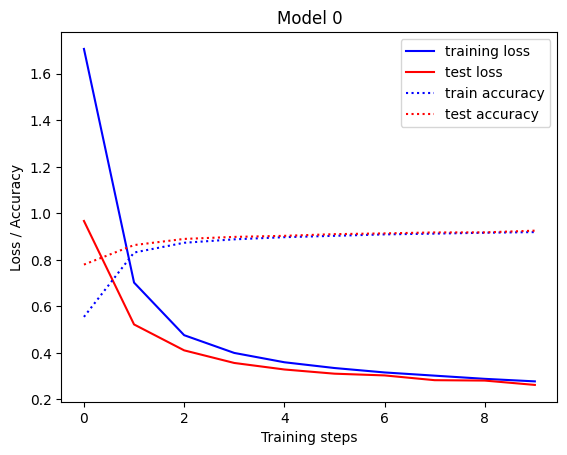

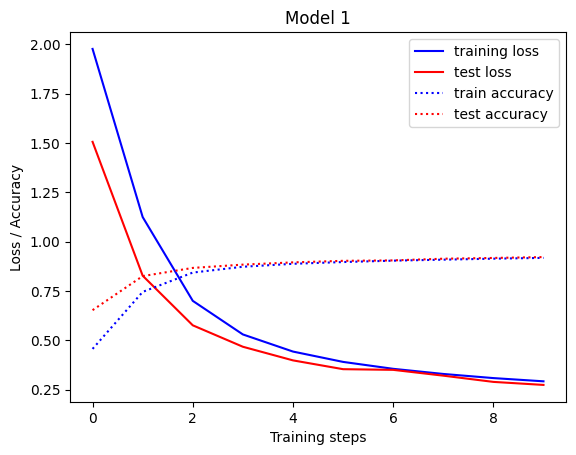

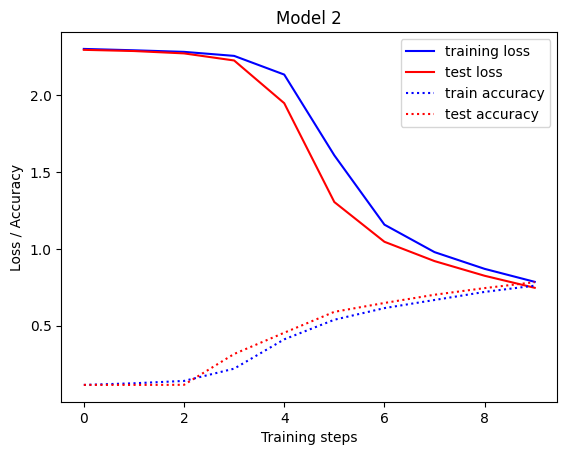

In [ ]:
visualization(train_loss_list, train_accuracy_list, test_loss_list, test_accuracy_list, name="Model 0")
visualization(train_loss_list1, train_accuracy_list1, test_loss_list1, test_accuracy_list1, name="Model 1")
visualization(train_loss_list2, train_accuracy_list2, test_loss_list2, test_accuracy_list2, name="Model 2")